# Transit Modelling Workbook  
  
  - ~~set up to read in TESS_SC~~
  - add option to clean up local cache for FITS downloads
  - ~~read in TIC stellar parameters~~
  - ~~limb-darkening prior~~
  - ~~set up initial transit model~~
  - ~~transit plot~~
  - ~~detrend data set (needs data flagging to complete)~~
  - ~~likelihood model~~
  - MCMC
  - transit model table
  
  
### How to setup detrend5

in the utils directory run:

`f2py3 -c detrend5.pyf polyfilter_ramp.f rqsort.f gaussj.f stdev.f --fcompiler=intelem`

If you are using gfortran remove the --fcompiler=intelem flag

### How to setup tfit5 module

in the utils directory run:

`f2py3 -c tfit5.pyf transitmodel.f keplerian.f ttcor.f occultquad.f mandelagol.f rqsort.f transitdur.f --fcompiler=intelem`

### Hack to get limb-darkening working

in the main directory execute the Makefile  
`make`

In [1]:
import os

import sys
sys.path.insert(0, "./utils/")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import emcee
import multiprocessing as mp #Enable multiprocessing

In [2]:
import autotransit as au

## Notebook parameters

In [3]:
toi_file="TOI_2020.09.08_14.21.51.csv" #nexsci catalogue for TOI parameters 

resultsdir="./results/" #Where to store results for each TOI

toi=2143.01 #The TOI we want to work with.

detrend_win=2.0 #Detrending Window [days]

modeltype=[1,0,0,0] #first digit ld: 0-no, 1-yes; second digit rhostar prior: 0-no, 1-yes; 3rd digit eccentricity.
                    #fourth digit is GPType: gptype=0 => no GP; gptype=1 => matern kernel

nwalkers=300 #number of walkers for MCMC
nsteps1 = 1000 #total length of chain will be nwalkers*nsteps
nsteps2 = 10000 #nstep1 is to check that MCMC is okay, nstep2 is the real work.
burninf=0.5 #burn-in for evalulating convergence
nthin=101
itermax=5 #maximum iterations allowed.

ncpu=24 #number of processors to use (adjust accordingly!)

## readtoicsv  
  
  This routine reads in a CSV file as downloaded from NexSCI (is there an API for this?)  
    
  The following values are stored in exocat_class

    exocat.ticid = TIC ID (int) 
    exocat.toiid = TOI ID (float)  
    exocat.toiid_str = TIC ID (string)
    exocat.ra = RA (float)
    exocat.dec = DEC (float)
    exocat.tmag = TESS mag (float)
    exocat.t0 = Centre of transit time (float) [days]
    exocat.t0err = uncertainity on t0 [days]
    exocat.per = orbital period (float) [days]
    exocat.pererr = uncertainity of per (float) [days]
    exocat.tdur = transit duration (float) [days]
    exocat.tdurerr = errors on tdur (float) [days]
    exocat.tdep = transit depth (float) [ppm]
    exocat.tdeperr = error on tdep (float) [ppm]


In [4]:
exocat=au.readtoicsv(toi_file)

## Fetch SC TESS Lightcurve

Using MAST API, pull down FITS files.  They are cached locally in 'download'.  

astropy is used to open up the FITS files and retrieve time, phot, phot error.  We are assuming 2-minute cadence for SC MAST data.  The lightcurve is returned in phot_class

The following values are stored in phot_class  

    phot.time = time stamps (np.array) [days]
    phot.flux = relative flux (np.array) 
    phot.ferr = reported uncertainity in phot.flux (np.array)
    phot.itime = integration time (np.array) [days]

In [5]:
toi=2143.01
toi_index = [j for j, x in enumerate(exocat.toiid) if x == toi][0]
print('TIC ID: ',exocat.ticid[toi_index],'| TOI ID: ',exocat.toiid[toi_index])

#Get SC Lightcurve for MAST

#Each Sector/Quarter of data is median corrected independently, then concatentated together.
phot_SC=au.get_tess_data(exocat.ticid[toi_index])  #give the TIC_ID and return SC data.

TIC ID:  103195323 | TOI ID:  2143.01
INFO: Found cached file ./download/mastDownload/TESS/tess2020133194932-s0025-0000000103195323-0182-s/tess2020133194932-s0025-0000000103195323-0182-s_lc.fits with expected size 1877760. [astroquery.query]
INFO: Found cached file ./download/mastDownload/TESS/tess2020160202036-s0026-0000000103195323-0188-s/tess2020160202036-s0026-0000000103195323-0188-s_lc.fits with expected size 1820160. [astroquery.query]
./download/mastDownload/TESS/tess2020133194932-s0025-0000000103195323-0182-s/tess2020133194932-s0025-0000000103195323-0182-s_lc.fits
./download/mastDownload/TESS/tess2020160202036-s0026-0000000103195323-0188-s/tess2020160202036-s0026-0000000103195323-0188-s_lc.fits


## Make a quick plot of the raw-lightcurve phased at the reported orbital period

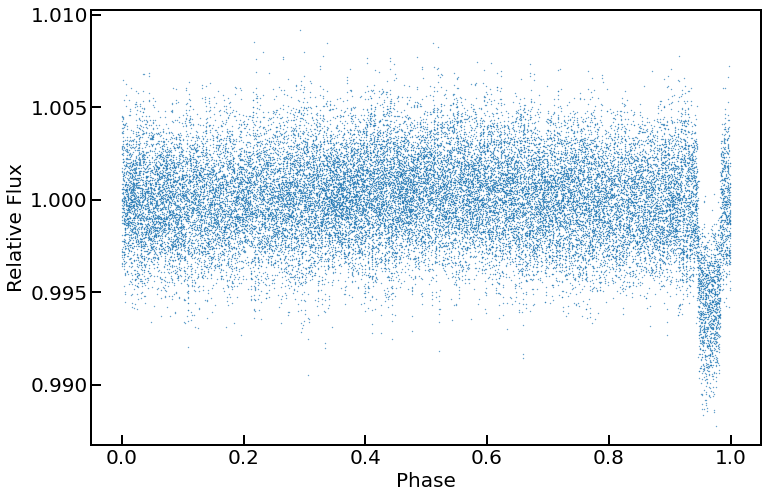

In [6]:
per=exocat.per[toi_index]

matplotlib.rcParams.update({'font.size': 20}) #adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
plt.figure(figsize=(12,8)) #adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', length=10, width=2)
ax.scatter(phot_SC.time/per-np.floor(phot_SC.time/per),phot_SC.flux,s=0.1)
ax.set_xlabel('Phase')
ax.set_ylabel('Relative Flux')

plt.show()

## Get stellar parameters  

These are pulled using MAST API for the TIC, except for q1,q2 which are calculated below.  

Results are stored in starpars_class()

    starpars.rhostar = mean stellar density (np.float) [cgs]
    starpars.rhostar_err = error on rhostar (np.float) [cgs]
    starpars.teff = stellar effective temperature (np.float) [K]
    starpars.teff_err = error on teff (np.float) [K]
    starpars.logg = log surface gravity (np.float) [cgs]
    starpars.logg_err = error on logg
    starpars.feh = metallicity (np.float) [Fe/H]
    starpars.feh_err = error on feh
    starpars.q1 = limb-darkening [Kipping]
    starpars.q1_err = error on q1
    starpars.q2 = limb-darkening [Kipping]
    starpars.q2_err = error on q2

In [7]:
#Get Stellar parameters from MAST
tic_output=au.ticAdvancedSearch(exocat.ticid[toi_index])

#Store stellar parameters in class.
starpars=au.starpars_class()
starpars.rhostar=tic_output['data'][0]['rho'] #CGS units
starpars.rhostar_err=tic_output['data'][0]['e_rho']
starpars.rhostar_ep=tic_output['data'][0]['epos_rho']
starpars.rhostar_em=tic_output['data'][0]['eneg_rho']
starpars.teff=tic_output['data'][0]['Teff']
starpars.teff_err=tic_output['data'][0]['e_Teff']
starpars.logg=tic_output['data'][0]['logg']
starpars.logg_err=tic_output['data'][0]['e_logg']
starpars.feh=tic_output['data'][0]['MH']
starpars.feh_err=tic_output['data'][0]['e_MH']
if starpars.feh==None:
    starpars.feh=0.0
    starpars.feh_err=1.0
print(starpars.teff,starpars.logg,starpars.feh)

7437 4.0884 0.0


## Get limb-darkening and priors

This is currently a hack that uses a commandline parameter. I need to pull the subroutine and build a wrapper to have the get_limb_q1q2() function work natively. 

In [8]:
#Example to get limb-darkening from Claret tables for the TESS bandpass given Teff, logg, [FeH]
q1,q2=au.get_limb_q1q2(starpars.teff,starpars.logg,starpars.feh)
print(q1,q2)

0.232115822656 0.15103033724656692


In [9]:
#Example to get priors.  The routine gets 100 samples and calculates standard deviation.
starpars.q1,starpars.q2,starpars.q1_err,starpars.q2_err=au.limbprior(starpars)
print(starpars.q1,starpars.q2,starpars.q1_err,starpars.q2_err)

0.232115822656 0.15103033724656692 0.0114561474420438 0.025644874625239285


## Set up initial model based on parameters from Nexsci table.  

The tables at NEXSCI are lacking, since they only report tdepth and tdur opposed to impact parameter and a/R* or rhostar.  This means we are guessing at a solution.  This fails when b>0.9. 

In [10]:
sol,serr=au.build_initial_sol(starpars,exocat,toi_index)
print(sol)

[0.229233, 0.0, 0.0, 0.232115822656, 0.15103033724656692, 0.0, 0.0, 0.0, 2012.0160179999657, 5.589479, 0.4, 0.07822658601140663, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


## Make a plot of our initial solution

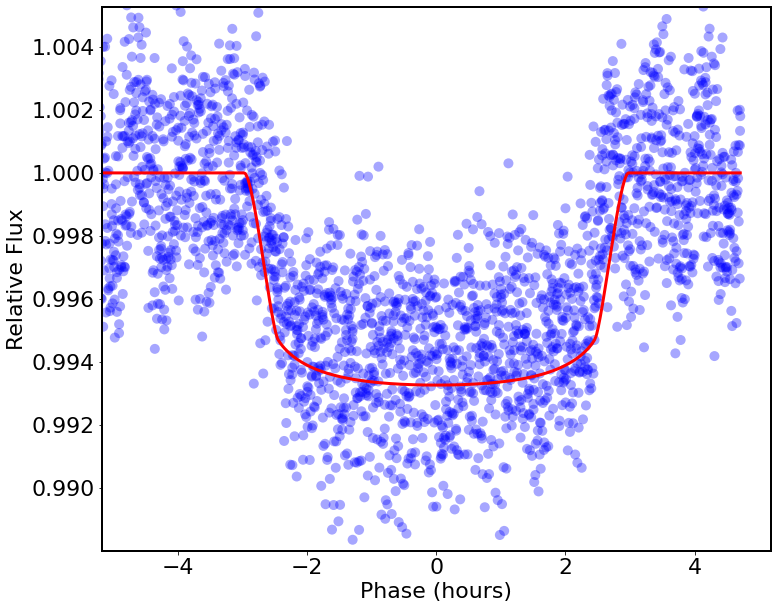

In [11]:
au.transitplot(phot_SC.time,phot_SC.flux,sol,itime=phot_SC.itime)

## Detrend Data

## Flag in-transit data to be used by the detrender

In [12]:
import tfit5

In [13]:
per=exocat.per[toi_index]
t0=exocat.t0[toi_index]
#Get Transit-duration
tdur=tfit5.transitdur(sol,1)/86400.0/per #Transit duration in phase.
#print(tdur)
phase=(phot_SC.time-t0)/per-np.floor((phot_SC.time-t0)/per)
phase[phase>0.5]=phase[phase>0.5]-1.0
npt=len(phase)
tflag=np.zeros(npt,dtype=int) #for marking transits
tflag[(phase<tdur/2)&(phase>-tdur/2)]=1 #mark in-transit-data.

tflag_m=np.zeros(npt,dtype=int) #data to use for modelling
tflag_m[(phase<tdur)&(phase>-tdur)]=1 

phot_detrend=au.detrend(phot_SC,detrend_win,tflag=tflag) #Run detrender with transits marked
phot=au.phot_class()
phot.time=np.copy(phot_detrend.time[tflag_m==1])
phot.flux=np.copy(phot_detrend.flux[tflag_m==1])+1.0
phot.ferr=np.copy(phot_detrend.ferr[tflag_m==1])
phot.itime=np.copy(phot_detrend.itime[tflag_m==1])

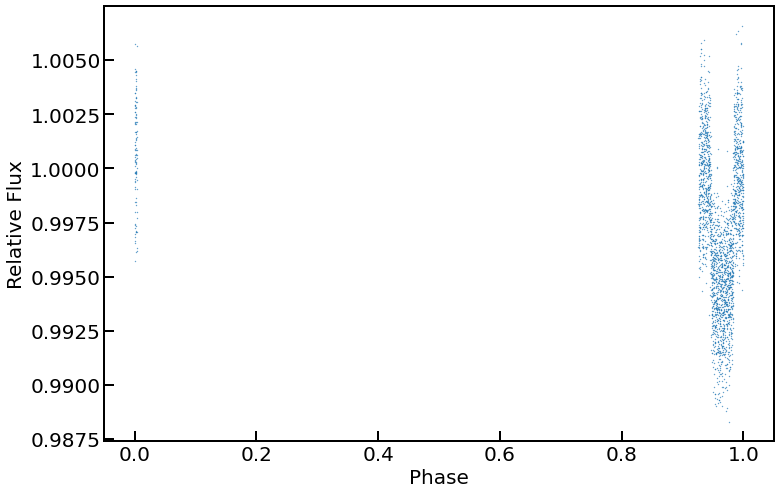

In [26]:
## Plotting stuff that can be removed
per=exocat.per[toi_index]
matplotlib.rcParams.update({'font.size': 20}) #adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
plt.figure(figsize=(12,8)) #adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', length=10, width=2)
ax.scatter(phot.time/per-np.floor(phot.time/per),phot.flux,s=0.1)
ax.set_xlabel('Phase')
ax.set_ylabel('Relative Flux')

plt.show()

## MCMC setup  

Our probability function is below.  This *purposely* uses global variables to avoid parallaziation bottlenecks with pickle files

In [27]:
def lnprob(x):#,phot,sol,serr,priors,rmin,rmax,ntt,tobs,omc,modeltype,diffs):

#    return -0.5 * np.sum(ivar * x ** 2)

    npar_sys=8 #number of system-wide parameters (e.g., limb-darkening)
    npar_pln=10 #planet specific parameters (e.g., r/R*)

    npar=len(sol)
    nbodies=int((npar-npar_sys)/npar_pln)
    sol3=np.copy(sol)
    j=-1
    for i in range(npar):
        if np.abs(serr[i]) > 1.0e-30:
            j=j+1
            #if i==0: #handled log(rhostar)
            #    sol3[i]=np.exp(x[j]) #rhostar
            #else:
            #    sol3[i]=x[j]
            sol3[i]=x[j]

    ascale=1.0 #default
    lscale=1.0 #default
    if modeltype[3]==0:
        dscale=x[len(x)-1] #photometric scale
    elif modeltype[3]==1:
        dscale=x[len(x)-3] #photometric scale
        ascale=x[len(x)-2] #photometric scale
        lscale=x[len(x)-1] #length scale for GP
    #print(sol3,dscale)

    logl=1.0e0
    #check validity of array
    badlpr=-np.inf #if outside bounds, then mark poor likelihood.
    for j in range(npar_sys): #system wide parameters
        if np.abs(serr[j]) > 1.0e-30:
            #if j==0: #mean stellar density is log-scale
            #    if np.log(sol3[j])<rmin[j] or np.log(sol3[j])>rmax[j]:
            #        logl=badlpr
            #else:
            #    if sol3[j]<rmin[j] or sol3[j]>rmax[j]:
            #        logl=badlpr
            if sol3[j]<rmin[j] or sol3[j]>rmax[j]:
                logl=badlpr
                #print(j,sol3[j],rmin[j],rmax[j])
    for i in range(nbodies): #planet specific parameters
        for j in range(npar_pln):
            n=npar_sys+i*npar_pln+j
            if np.abs(serr[n]) > 1.0e-30:
                if sol3[n]<rmin[j+npar_sys] or sol3[n]>rmax[j+npar_sys]:
                    logl=badlpr
                    #print(n,j+npar_sys,sol3[n],rmin[j+npar_sys],rmax[j+npar_sys])

    #check dscale
    if dscale <= 0.0:
        logl=badlpr
    if ascale <= 0.0:
        logl=badlpr
    if lscale <= 0.0:
        logl=badlpr

    npt=len(phot.time)
    #print(sol3)
    if logl>0.0:
        ans = au.transitmodel (sol3, phot.time, itime=phot.itime, ntt=ntt, tobs=tobs, omc=omc)
        if np.isnan(np.sum(ans))==False:
            if modeltype[3]==0: #chi-sq likelihood
                #logl=-0.5*np.sum((phot.flux-ans)*(phot.flux-ans)/(phot.ferr*phot.ferr*dscale*dscale))
                logl=-0.5*(sum(np.log(phot.ferr*phot.ferr*dscale*dscale))\
                 +sum((phot.flux-ans)*(phot.flux-ans)/(phot.ferr*phot.ferr*dscale*dscale)))
            elif modeltype[3]==1: #Matern 3/2 Kernel
                kernel=makekernelm32(phot,phot,dscale,ascale,lscale,diffs)
                factor, low = lin.cho_factor(kernel)
                logDK =2*np.sum(np.log(np.diag(factor)))
                ymr = ans-phot.flux
                if np.isnan(np.sum(factor))==False:
                    logl=-0.5*(np.dot(ymr, lin.cho_solve((factor, low), ymr))+ logDK) #+ npt*np.log(2*np.pi))
                else:
                    logl=badlpr
        else:
            #print('nan!',sol3)
            logl=badlpr
            

    #add in priors

    ##prior of ln(p)
    #logl+=np.log(sol3[0])

    for i in range(npar): #npar only includes transit parameters, not hyper parameters
        np1=np.mod(i-npar_sys,10) #deal with large r/R* when b>1.
        if i>=npar_sys:
            if np1==2:
                if sol3[i]>1.0:
                    logl+=-sol3[i]*sol3[i]

        if priors[i]!=None:
            pchoose=np.random.rand()
            if pchoose>=0.5:
                prior1=-0.5*np.power((sol3[i]-priors[i][0])/priors[i][1],2)
            else:
                prior1=-0.5*np.power((sol3[i]-priors[i][0])/priors[i][2],2)
            #print(logl,prior1,sol3[i],priors[i])
            logl+=prior1

    #Catch NaNs
    if np.isnan(logl):
        logl=badlpr

    return logl;

In [28]:
ntt=0;tobs=0;omc=0 #disabling TTVs

In [29]:
#Setup Directories
filedir=resultsdir+'toi'+str(int(exocat.toiid[toi_index]))+'.n/'
if os.path.isdir(filedir)==False:
    os.mkdir(filedir)

#File to store MCMC results
chainfile=filedir+'chain_'
if modeltype[0]==1:
    chainfile+='ld_'
if modeltype[1]==1:
    chainfile+='rh_'
if modeltype[2]==1:
    chainfile+='ec_'
if modeltype[3]==1:
    chainfile+='gpm32_'
chainfile+=str(exocat.toiid[toi_index])+'.h5' #MCMC results are stored in an HDF5 file
#print(chainfile)

if modeltype[3]==0:
    nhyper=1 #number of hyperparameters needed for noise-model.  
elif modeltype[3]==1:
    nhyper=3
else: #catch invalid choices for gptype => default to chi-sq likelihood 
    nhyper=1
    modeltype[3]=0

#default priors
priors=au.setup_priors(sol,nhyper)

#limb-darkening
if modeltype[0]==1:
    priors[3]=[starpars.q1,starpars.q1_err,starpars.q1_err]
    priors[4]=[starpars.q2,starpars.q2_err,starpars.q2_err]
    print('p:',priors[3])
    print('p:',priors[4])

#mean-stellar density
if modeltype[1]==1:
    priors[0]=[starpars.rhostar,starpars.rhostar_ep,starpars.rhostar_em]
    print(priors[0])

#eccentric models
if modeltype[2]==1:
    serr=au.addeccn(serr)

#Write out initial solution and priors
au.write_n1dat(exocat.toiid[toi_index],sol,serr,modeltype,filedir)
    
# Set up MCMC
if modeltype[3]==1:
    diffs=au.calcdiffs(phot,phot) #pre-calculate to speed up GPs
rsuf,rmin,rmax=au.setup_gibbs()
x,p0,ndim=au.setup_walkers(sol,serr,phot_SC,rsuf,rmin,rmax,nwalkers,modeltype)

#test lnprob

lp=lnprob(p0[1])#,phot,sol,serr,priors,rmin,rmax,ntt,tobs,omc,modeltype,diffs)
print('p0:',lp)
lp=lnprob(x)#,    phot,sol,serr,priors,rmin,rmax,ntt,tobs,omc,modeltype,diffs)
print('x:',lp)

p: [0.232115822656, 0.0114561474420438, 0.0114561474420438]
p: [0.15103033724656692, 0.025644874625239285, 0.025644874625239285]
p0: 9889.829783467216
x: 12345.68001795147


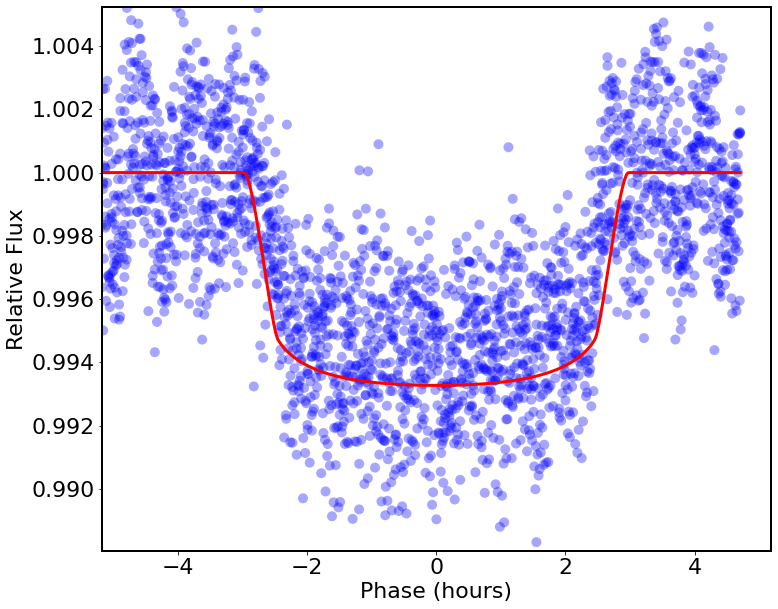

In [30]:
npar_sys=8 #number of system-wide parameters (e.g., limb-darkening)
npar_pln=10 #planet specific parameters (e.g., r/R*)

npar=len(sol)
nbodies=int((npar-npar_sys)/npar_pln)
sol3=np.copy(sol)
j=-1
for i in range(npar):
    if np.abs(serr[i]) > 1.0e-30:
        j=j+1
        #if i==0: #handled log(rhostar)
        #    sol3[i]=np.exp(x[j]) #rhostar
        #else:
        #    sol3[i]=x[j]
        sol3[i]=x[j]
        
au.transitplot(phot.time,phot.flux,sol3,itime=phot.itime)

In [ ]:
# Set up sampler

# Set up the backend to save Chains to a file -- this will also allow for restarts.
# Don't forget to clear it in case the file already exists
# If the file exists, new chains will be appended. 
backend = emcee.backends.HDFBackend(chainfile)
backend.reset(nwalkers, ndim)

#For the first run in the notebook, we run the sampler initialized with p0
with mp.Pool(processes=ncpu) as pool:
    #sampler = emcee.EnsembleSampler(nwalkers, ndim, au.lnprob, \
    #                                args=[phot,sol,serr,priors,rmin,rmax,ntt,\
    #                                      tobs,omc,modeltype,diffs],\
    #                                pool=pool,backend=backend)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, \
                                            pool=pool,backend=backend)
    sampler.run_mcmc(p0, nsteps1, progress=True, store=True)

#we evaluate convergence and generate more chains if necessary. 


samples = sampler.get_chain(flat=True)
nthin=101
runtest=np.array(au.checkperT0(samples,burninf,nthin,sol,serr))
print('runtest:',runtest)
if int(np.sum(runtest[runtest<1.0]/runtest[runtest<1.0]))==4.0:
    tauflag=1 #flag for looping until convergence is met.
else:
    tauflag=0 #run-away

npars=len(x)
iter=0

while tauflag==1:
    iter+=1
    print('Iteration # ',iter,exocat.toiid[toi_index])

    chainT = sampler.get_chain()[:, :].T
    npt=len(phot.time)
    Rc=au.gelmanrubin(chainT,burninf,npt) #npt is number of data points
    print('Rc:',Rc)

    tauflag=0
    for jj in range(npars):
        chainT = sampler.get_chain()[:, :, jj].T
        lenC = int(chainT.shape[1]*burninf)
        chainT = chainT[:,lenC:]
        N=chainT.shape[1]
        tau=au.autocorr_new(chainT[:, :])
        print(tau,N/50)
        if tau > N/50:
            tauflag=1

    if iter>itermax:
        tauflag=0 #stop loop.. can't go on forever.

    if tauflag==1:
        with mp.Pool(processes=ncpu) as pool:
            #sampler = emcee.EnsembleSampler(nwalkers, ndim, au.lnprob, \
            #                                args=[phot,sol,serr,priors,rmin,rmax,ntt,\
            #                                tobs,omc,modeltype,diffs],\
            #                                pool=pool,backend=backend)
            sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, \
                                            pool=pool,backend=backend)
            sampler.run_mcmc(None, nsteps2, progress=True, store=True)

print('Done!')

100%|██████████| 1000/1000 [15:20<00:00,  1.09it/s]


runtest: [0.00064074 0.00056369 0.00021745 0.00019656]
Iteration #  1 2143.01
Rc: [1.26300218 1.1393933  1.14534754 1.14317331 1.12165959 1.13712709
 1.28760712 1.19128537 1.15318605]
45.34368002052984 10.0
37.71867338381317 10.0
39.71866385404411 10.0
39.38729234121277 10.0
37.49568283816085 10.0
39.61157099701767 10.0
46.1082328687935 10.0
40.41133833111769 10.0
39.69612869062151 10.0


 59%|█████▉    | 5904/10000 [1:26:09<1:01:50,  1.10it/s]

In [20]:
## For Debuging
import importlib

In [24]:
importlib.reload(au)

<module 'autotransit' from '/home/rowe/Documents/python/autotransit/autotransit.py'>